<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0822_keras%EB%B3%B5%EC%8A%B5/keras(IMDB%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB를 이용한 이진 분류

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [15]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# from scipy import stats
# import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("그림 저장:", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

## 1.데이터셋 로드
- train_data 와 test_data : 리뷰의 목록으로 하나의 데이터는 단어 인덱스의 리스트임
- train_labels 와 test_labels : 긍정(1)과 부정(0)을 나타내는 리스트

In [2]:
from keras.datasets import imdb
# num_words=10000 => 자주 나타나는 단어 1만개만 사용
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


In [3]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


###  1) 단어 인덱스를 영어단어로 바꿔보기

In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value,key) for (key, value) in word_index.items()])
decoded_view = ' '.join([reverse_word_index.get(i-3,"?") for i in train_data[0]])
decoded_view

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 2.데이터 준비
- 신경망에는 텐서를 주입해야 하므로 리스트를 텐서로 바꿔야 합니다.


### 1) 리스트를 텐서로 바꾸는 방법
    1) 리스트에 패딩을 추가하고 samples, sequence_length 크기의 정수 텐서로 변환
    2) 리스트를 원핫 인코딩하고 부동 소수 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫번째 층으로 사용하기

### 2) 원핫 인코딩하기

In [5]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # print(dimension)
    # (25000, 10000) 크기의 행렬 만들기
    results = np.zeros((len(sequences), dimension))
    # 각 문장마다 단어부분에 1로 변환해주기
    for i, sequence in enumerate(sequences):
        
        # i는 문장
        # sequence는 단어 인덱스
        results[i, sequence] = 1,
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

### 3) 레이블을 float으로 변환

In [6]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 3.신경망 모델 만들기
- 이중분류문제에 대해서는 relu활성화 함수를 사용하여 완전 연결층으로 쌓는것이 제일 좋은 방법입니다.

#### 1) 완전 연결층이란?
```Dense(16, activation='relu')```

- Dense층에 전달하는 16은 은닉 유닛의 개수로, 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 됩니다.
- 16개의 은닉 유닛이 있다는 것은 가중치 행렬 w의 크기가 (input_dimension, 16)이라는 뜻으로 입력 데이터와 w를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영되고 편향 벡터 b를 더하고 relu연산을 적용합니다.
- 은닉 유닛을 늘리면 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원하지 않는 패턴을 학습할 수도 있습니다.

#### 2) 활성화 함수란?
```output = relu(dot(X, input) + b)```
- 활성화 함수는 비선형성이라고 부릅니다
- 활성화함수가 없는 ```output = dot(X, input)+b```의 경우 선형 변환만 학습할 수 있는데 선형변환을 학습한 층의 가설 공간은 입력데이터를 16차원의 공간으로 바꾸는 가능한 모든 선평 변환의 집합입니다. 이런 가설 공간은 아무리 층을 깊게 쌓아도 선형 연산이기 때문에 층을 여러 개로 구성하는 장점이 없습니다. 
- relu는 음수를 0으로 만드는 함수입니다
- sigmoid는 임의의 값을 [0,1]사이로 압축하여 출력 값을 확률처럼 해석할 수 있습니다.


### 3) 모델 정의

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## 4.모델 컴파일

### 1) 손실함수
손실함수는 신경망의 예측과 진짜 타깃(신경망의 출력으로 기대하는 값)의 차이를 점수로 계산한 것입니다
- binary_crossentropy : 2개의 클래스가 있는 분류문제
- categorical_crossentropy : 여러개 클래스가 있는 분류. 두 확률 사이의 거리를 측정함.  레이블이 인코딩되어 있을것이라 기대
- mean_squared_error(mse : 평균 제곱 오차) : 회귀문제, 예측과 타깃사이 거리의 제곱
- mean_absolute_error(mae : 평균절대 오차) : 회귀문제. 예측과 타깃사이거리의 절댓값
- crossengropy : 확률 분포간의 차이를 측정
- CTC : 시퀀스 학습문제
- sparse_categorical_crossentropy : 정수 레이블 사용


### 2) 옵티마이저와 역전파 알고리즘
옵티마이저는 손실점수가 감소되는 방향으로 가중치 값을 조금씩 수정하는 것입니다. 이런 수정과정은 역전파 알고리즘을 구현한 옵티마이저가 담당합니다.


초기에는 네트워크의 가중치가 랜덤한 값으로 할당되어 손실점수가 높습니다. 네트워크가 모든 샘플을 처리하면서 가중치가 올바른 방향으로 조정되고 손실점수가 감소하도록 훈련을 반복합니다. 


#### 이중분류의 컴파일
- 손실함수 : 이진분류 문제이고 신경망의 출력이 확률이므로 binary_crossentropy 를 하기에 적당. 원본 분포와 예측분포사이를 측정
- 옵티마이저 : rmsprop





In [8]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

## 5.훈련 검증

### 1) 검증데이터 준비

In [9]:
X_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### 2) 훈련 및 검증
- history는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리입니다.

In [10]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5364 - acc: 0.7838 - val_loss: 0.4261 - val_acc: 0.8298
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.3206 - acc: 0.9001 - val_loss: 0.3483 - val_acc: 0.8624
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2324 - acc: 0.9271 - val_loss: 0.2819 - val_acc: 0.8898
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1832 - acc: 0.9393 - val_loss: 0.2861 - val_acc: 0.8853
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1475 - acc: 0.9536 - val_loss: 0.2871 - val_acc: 0.8854
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1215 - acc: 0.9629 - val_loss: 0.3051 - val_acc: 0.8833
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1002 - acc: 0.9705 - val_loss: 0.3086 - val_acc: 0.8828
Epoch 8/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0852 - a

### 3) 모델 훈련 history확인

In [11]:
history_dict =history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## 6.손실과 정확도 그래프그리기
- epochs가 커질수로 과적합되어 훈련손실은 줄어들고 검증손실은 커지며, 훈련의 정확도는 커지고 검증의 정확도는 줄어듭니다

### 1) 훈련과 검증 손실 그래프그리기

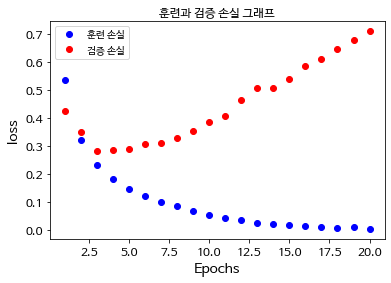

In [17]:
import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='훈련 손실')
plt.plot(epochs, val_loss, 'ro', label='검증 손실')
plt.title('훈련과 검증 손실 그래프')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


### 2) 훈련과 검증 정확도 그래프그리기

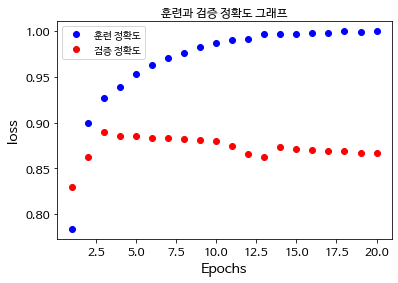

In [16]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='훈련 정확도')
plt.plot(epochs, val_acc, 'ro', label='검증 정확도')
plt.title('훈련과 검증 정확도 그래프')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


## 7.손실과 정확도 출력

In [20]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

196/196 [==============================] - 1s 5ms/step - loss: 0.7609 - acc: 0.8500
test loss, test acc: [0.7609128952026367, 0.8499600291252136]


## 8.모델 예측
- ```predict```함수를 이용하여 리뷰가 긍정일 **확률**을 예측할 수 있습니다.

In [22]:
predictions = model.predict(X_test[:3])
predictions

array([[0.00679854],
       [1.        ],
       [0.97863984]], dtype=float32)

## 9.추가실험


### 1) 은닉층이 3개일 경우 - 정확도가 증가했지만 손실도 매우 증가함

In [23]:
from keras import models
from keras import layers

# 모델 설계
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 컴파일
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# 훈련 검증
model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Epoch 1/20
30/30 [==============================] - 2s 52ms/step - loss: 0.5389 - acc: 0.7738 - val_loss: 0.3920 - val_acc: 0.8718
Epoch 2/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3124 - acc: 0.8995 - val_loss: 0.3027 - val_acc: 0.8869
Epoch 3/20
30/30 [==============================] - 1s 39ms/step - loss: 0.2219 - acc: 0.9258 - val_loss: 0.2969 - val_acc: 0.8823
Epoch 4/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1713 - acc: 0.9439 - val_loss: 0.2747 - val_acc: 0.8898
Epoch 5/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1356 - acc: 0.9561 - val_loss: 0.2937 - val_acc: 0.8871
Epoch 6/20
30/30 [==============================] - 1s 39ms/step - loss: 0.1115 - acc: 0.9649 - val_loss: 0.3034 - val_acc: 0.8843
Epoch 7/20
30/30 [==============================] - 1s 41ms/step - loss: 0.0871 - acc: 0.9727 - val_loss: 0.3267 - val_acc: 0.8836
Epoch 8/20
30/30 [==============================] - 1s 40ms/step - loss: 0.0678 - a

### 2) 층의 유닛을 64개로 늘리기 - 정확도가 증가했지만 손실도 매우 증가함

In [25]:
from keras import models
from keras import layers

# 모델 설계
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 컴파일
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# 훈련 검증
model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Epoch 1/20
30/30 [==============================] - 2s 60ms/step - loss: 0.4851 - acc: 0.7849 - val_loss: 0.3512 - val_acc: 0.8648
Epoch 2/20
30/30 [==============================] - 1s 48ms/step - loss: 0.2702 - acc: 0.9072 - val_loss: 0.2891 - val_acc: 0.8885
Epoch 3/20
30/30 [==============================] - 1s 47ms/step - loss: 0.1976 - acc: 0.9303 - val_loss: 0.2834 - val_acc: 0.8870
Epoch 4/20
30/30 [==============================] - 1s 47ms/step - loss: 0.1588 - acc: 0.9435 - val_loss: 0.3305 - val_acc: 0.8728
Epoch 5/20
30/30 [==============================] - 1s 49ms/step - loss: 0.1199 - acc: 0.9615 - val_loss: 0.3231 - val_acc: 0.8787
Epoch 6/20
30/30 [==============================] - 1s 48ms/step - loss: 0.0955 - acc: 0.9700 - val_loss: 0.3203 - val_acc: 0.8828
Epoch 7/20
30/30 [==============================] - 1s 48ms/step - loss: 0.0796 - acc: 0.9746 - val_loss: 0.3468 - val_acc: 0.8814
Epoch 8/20
30/30 [==============================] - 1s 50ms/step - loss: 0.0605 - a

### 3) loss를 mse - 정확도가 살짝 증가하고 손실이 매우 감소함

In [26]:
from keras import models
from keras import layers

# 모델 설계
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 컴파일
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['acc'])

# 훈련 검증
model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Epoch 1/20
30/30 [==============================] - 3s 75ms/step - loss: 0.1625 - acc: 0.7824 - val_loss: 0.1077 - val_acc: 0.8711
Epoch 2/20
30/30 [==============================] - 1s 46ms/step - loss: 0.0814 - acc: 0.9061 - val_loss: 0.0937 - val_acc: 0.8792
Epoch 3/20
30/30 [==============================] - 1s 48ms/step - loss: 0.0587 - acc: 0.9315 - val_loss: 0.0874 - val_acc: 0.8849
Epoch 4/20
30/30 [==============================] - 1s 46ms/step - loss: 0.0451 - acc: 0.9491 - val_loss: 0.0839 - val_acc: 0.8847
Epoch 5/20
30/30 [==============================] - 1s 46ms/step - loss: 0.0360 - acc: 0.9593 - val_loss: 0.0905 - val_acc: 0.8765
Epoch 6/20
30/30 [==============================] - 1s 46ms/step - loss: 0.0273 - acc: 0.9721 - val_loss: 0.0875 - val_acc: 0.8806
Epoch 7/20
30/30 [==============================] - 1s 46ms/step - loss: 0.0239 - acc: 0.9749 - val_loss: 0.0947 - val_acc: 0.8744
Epoch 8/20
30/30 [==============================] - 2s 53ms/step - loss: 0.0185 - a

### 4) activation을 'tanh' - 정확도가 줄고 손실이 매우 증가

In [27]:
from keras import models
from keras import layers

# 모델 설계
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

# 컴파일
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# 훈련 검증
model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Epoch 1/20
30/30 [==============================] - 3s 61ms/step - loss: 0.4849 - acc: 0.8036 - val_loss: 0.3718 - val_acc: 0.8618
Epoch 2/20
30/30 [==============================] - 1s 48ms/step - loss: 0.2759 - acc: 0.9098 - val_loss: 0.2868 - val_acc: 0.8876
Epoch 3/20
30/30 [==============================] - 1s 47ms/step - loss: 0.1973 - acc: 0.9341 - val_loss: 0.2738 - val_acc: 0.8892
Epoch 4/20
30/30 [==============================] - 1s 48ms/step - loss: 0.1500 - acc: 0.9477 - val_loss: 0.2783 - val_acc: 0.8881
Epoch 5/20
30/30 [==============================] - 1s 48ms/step - loss: 0.1128 - acc: 0.9636 - val_loss: 0.3026 - val_acc: 0.8853
Epoch 6/20
30/30 [==============================] - 1s 49ms/step - loss: 0.0931 - acc: 0.9698 - val_loss: 0.3328 - val_acc: 0.8811
Epoch 7/20
30/30 [==============================] - 1s 48ms/step - loss: 0.0713 - acc: 0.9781 - val_loss: 0.3664 - val_acc: 0.8784
Epoch 8/20
30/30 [==============================] - 1s 49ms/step - loss: 0.0525 - a